Mount your google drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Command for running LSTM script (not needed for the pre-trained model)

In [ ]:
# !python /content/gdrive/MyDrive/AS3/lfd_assignment3.py --train_file /content/gdrive/MyDrive/AS3/train.txt --dev_file /content/gdrive/MyDrive/AS3/dev.txt --test_file /content/gdrive/MyDrive/AS3/test.txt --embeddings /content/gdrive/MyDrive/AS3/glove_reviews.json -fr

Install transformer library

In [ ]:
!pip install transformers

Import libraries and packages needed for this notebook and set random seeds (this will not make the experiment fully reproducible)

In [ ]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from transformers import set_seed, TFAutoModelForSequenceClassification, AutoTokenizer
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

seed = 101
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
set_seed(seed)

Read in train, dev and test files

In [ ]:
def read_corpus(corpus_file):
    '''Read in review data set and returns docs and labels'''
    documents = []
    labels = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            tokens = line.strip()
            documents.append(" ".join(tokens.split()[3:]).strip())
            # 6-class problem: books, camera, dvd, health, music, software
            labels.append(tokens.split()[0])
    return documents, labels

# Read in the data and embeddings
X_train, Y_train = read_corpus("/content/gdrive/MyDrive/AS3/train.txt")
X_dev, Y_dev = read_corpus("/content/gdrive/MyDrive/AS3/dev.txt")
X_test, Y_test = read_corpus("/content/gdrive/MyDrive/AS3/test.txt")

Load in model and tokenizer from Huggingface

In [ ]:
#Best model
lm = "bert-base-cased"
# Other LMs we tried
#lm = "bert-base-uncased"
#lm = "distilbert-base-cased"
#lm = "distilbert-base-uncased"
#lm = "roberta-base"
#lm = "albert-base-v2"
#lm = "microsoft/deberta-base"
#lm = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(lm)
model = TFAutoModelForSequenceClassification.from_pretrained(lm, num_labels=6)
tokens_train = tokenizer(X_train, padding=True, max_length=300,
truncation=True, return_tensors="np").data
tokens_dev = tokenizer(X_dev, padding=True, max_length=300,
truncation=True, return_tensors="np").data
tokens_test = tokenizer(X_test, padding=True, max_length=300,
truncation=True, return_tensors="np").data

Set loss function, learning rate or learning rate scheduler and optimizer

In [ ]:
loss_function = CategoricalCrossentropy(from_logits=True)

In [ ]:
initial_learning_rate = 2e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate,
    decay_steps=1000,
    end_learning_rate=1e-7,
    power=1.0,
)

In [ ]:
optim = Adam(learning_rate=lr_schedule)

Transform string labels to one-hot encodings

In [ ]:
encoder = LabelBinarizer()
Y_train_bin = encoder.fit_transform(Y_train)
Y_dev_bin = encoder.fit_transform(Y_dev)
Y_test_bin = encoder.fit_transform(Y_test)

Compile and fit the model using an early stopping callback

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(loss=loss_function, optimizer=optim, metrics=['accuracy'])
model.fit(tokens_train, Y_train_bin, verbose=1, epochs=50, callbacks=[callback],
batch_size=16, validation_data=(tokens_dev, Y_dev_bin))

Print loss and accuracy on the test set

In [ ]:
results = model.evaluate(tokens_test, Y_test_bin, batch_size=16)
print(results)

38/38 [==============================] - 5s 122ms/step - loss: 0.1449 - accuracy: 0.9517
[0.14490105211734772, 0.9516666531562805]


Print classification report and confusion matrix on the test set

In [ ]:
def print_measures(Y_test, Y_pred, plot_cm=False):
    ''' Takes in true labels Y_test, predicted labels Y_pred and a boolean
    plot_cm (default=False). Prints a classification report (precision, recall
    and F1 score for each class) and a confusion matrix with labels. To plot a
    visualization of the confusion matrix, set plot_cm to True'''
    report = classification_report(Y_test, Y_pred)

    # Create a confusion matrix with labels
    labels = np.unique(Y_test)
    cm = confusion_matrix(Y_test, Y_pred, labels=labels)
    cm_labeled = pd.DataFrame(cm, index=labels, columns=labels)

    print("Classification report:\n\n", report)
    print("Confusion matrix:\n\n", cm_labeled)

    if plot_cm:
      # Plot confusion matrix using pyplot
        display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        display.plot()
        plt.show()

In [ ]:
predictions = model.predict(tokens_test)['logits']
Y_pred = encoder.inverse_transform(predictions)

Classification report:

               precision    recall  f1-score   support

       books       0.95      0.97      0.96       108
      camera       0.96      0.94      0.95        99
         dvd       0.94      0.95      0.95       105
      health       0.94      0.95      0.95        82
       music       0.96      0.97      0.97       111
    software       0.95      0.92      0.93        95

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600

Confusion matrix:

           books  camera  dvd  health  music  software
books       105       0    1       0      2         0
camera        0      93    2       2      0         2
dvd           1       0  100       1      2         1
health        0       2    0      78      0         2
music         1       0    2       0    108         0
software      3       2    1       2      0        87


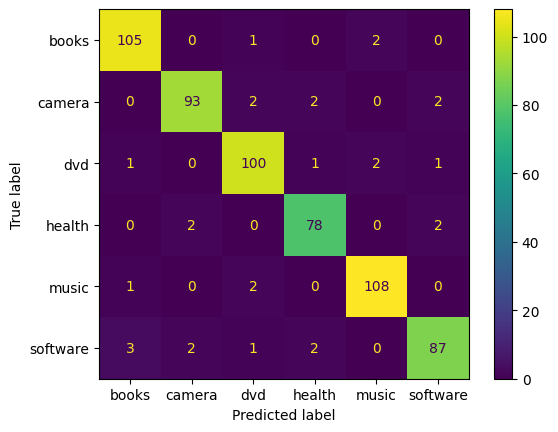

In [ ]:
print_measures(Y_test, Y_pred, plot_cm=True)